### Step 1: Import Libraries

First, we'll bring in all the necessary tools for our analysis. `pandas` is for data manipulation, `matplotlib` and `seaborn` are for creating visualizations, and `sklearn` and `scipy` will help with the clustering.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

### Step 2: Create Dataset

To simulate real-world data, let's create a small dataset representing delivery information, including unique IDs, pickup times, and dropoff times. This mimics data we might get from a database like MySQL.

In [3]:
data = {
    "delivery_id": [1,2,3,4,5,6,7,8,9,10],
    "pickup_time": [
        "2025-01-01 10:00:00",
        "2025-01-01 11:00:00",
        "2025-01-02 09:30:00",
        "2025-01-03 14:00:00",
        "2025-01-04 10:15:00",
        "2025-01-04 18:00:00",
        "2025-01-05 12:00:00",
        "2025-01-06 09:00:00",
        "2025-01-06 16:00:00",
        "2025-01-07 13:00:00"
    ],
    "dropoff_time": [
        "2025-01-01 10:35:00",
        "2025-01-01 11:50:00",
        "2025-01-02 10:05:00",
        "2025-01-03 15:10:00",
        "2025-01-04 11:00:00",
        "2025-01-04 19:30:00",
        "2025-01-05 12:40:00",
        "2025-01-06 09:20:00",
        "2025-01-06 17:05:00",
        "2025-01-07 13:45:00"
    ]
}

df = pd.DataFrame(data)

### Step 3: Preprocessing

Our time data is currently stored as strings, which isn't ideal for calculations. Here, we'll convert the 'pickup_time' and 'dropoff_time' columns into proper datetime objects, making them ready for time-based computations.

In [4]:
df["pickup_time"] = pd.to_datetime(df["pickup_time"])
df["dropoff_time"] = pd.to_datetime(df["dropoff_time"])

### Step 4: Feature Engineering

Now, let's create some new, useful features from our existing data. We'll calculate the `delivery_time_minutes` for each delivery and identify if a delivery occurred on a `weekend` day. These features will be crucial for our clustering analysis.

In [5]:
df["delivery_time_minutes"] = (
    df["dropoff_time"] - df["pickup_time"]
).dt.total_seconds() / 60

df["day_of_week"] = df["pickup_time"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

### Step 5: Aggregation

We'll group our data by `delivery_id` and aggregate the newly engineered features. Specifically, we'll calculate the average delivery time, its variance (to understand consistency), and whether the delivery was on a weekend. If there's no variance for a single delivery, we'll fill that with 0.

In [6]:
feature_df = df.groupby("delivery_id").agg(
    avg_time=("delivery_time_minutes", "mean"),
    variance_time=("delivery_time_minutes", "var"),
    weekend=("is_weekend", "max")
).fillna(0)

### Step 6: Normalization

Before clustering, it's good practice to normalize our features. This ensures that features with larger numerical ranges don't dominate the clustering process. We'll use `StandardScaler` to transform our data so it has a mean of 0 and a standard deviation of 1.

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

### Step 7: Hierarchical Clustering

Now, let's perform the hierarchical clustering. We'll use the `ward` method, which minimizes the variance within each cluster. This step calculates the distances between data points and links them to form a hierarchy.

In [8]:
linked = linkage(scaled_features, method="ward")

### Step 8: Dendrogram

A dendrogram is a visual representation of the hierarchical clustering. It helps us decide how many clusters are appropriate for our data by showing the mergers of clusters and their distances. We'll plot one to get a better understanding.

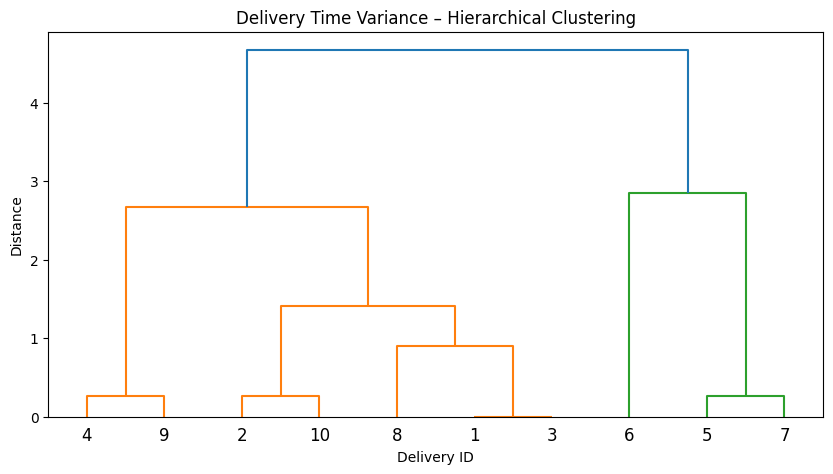

In [9]:
plt.figure(figsize=(10,5))
dendrogram(linked, labels=feature_df.index)
plt.title("Delivery Time Variance – Hierarchical Clustering")
plt.xlabel("Delivery ID")
plt.ylabel("Distance")
plt.show()

### Step 9: Cluster Formation

Based on the dendrogram (or a predefined choice), we'll now form our clusters. We'll choose to form 3 clusters (`t=3`) using the `maxclust` criterion, meaning we want exactly three clusters.

In [10]:
feature_df["cluster"] = fcluster(linked, t=3, criterion="maxclust")

### Step 10: Cluster Summary

After assigning each delivery to a cluster, it's time to understand what defines each cluster. We'll calculate the mean of our features for each cluster to see if there are distinct patterns or characteristics among them.

In [11]:
cluster_summary = feature_df.groupby("cluster").mean()
print(cluster_summary)

          avg_time  variance_time  weekend
cluster                                   
1        45.714286            0.0      0.0
2        42.500000            0.0      1.0
3        90.000000            0.0      1.0


### Step 11: Export CSV

Finally, we'll save our `feature_df` (which now includes the cluster assignments) to a CSV file. This allows us to easily use these results in other applications or for further analysis.

In [12]:
feature_df.to_csv("delivery_cluster_mapping.csv")

print("CSV file saved: delivery_cluster_mapping.csv")

CSV file saved: delivery_cluster_mapping.csv
